# Chroma와 LangGraph를 활용한 모듈형 RAG 시스템

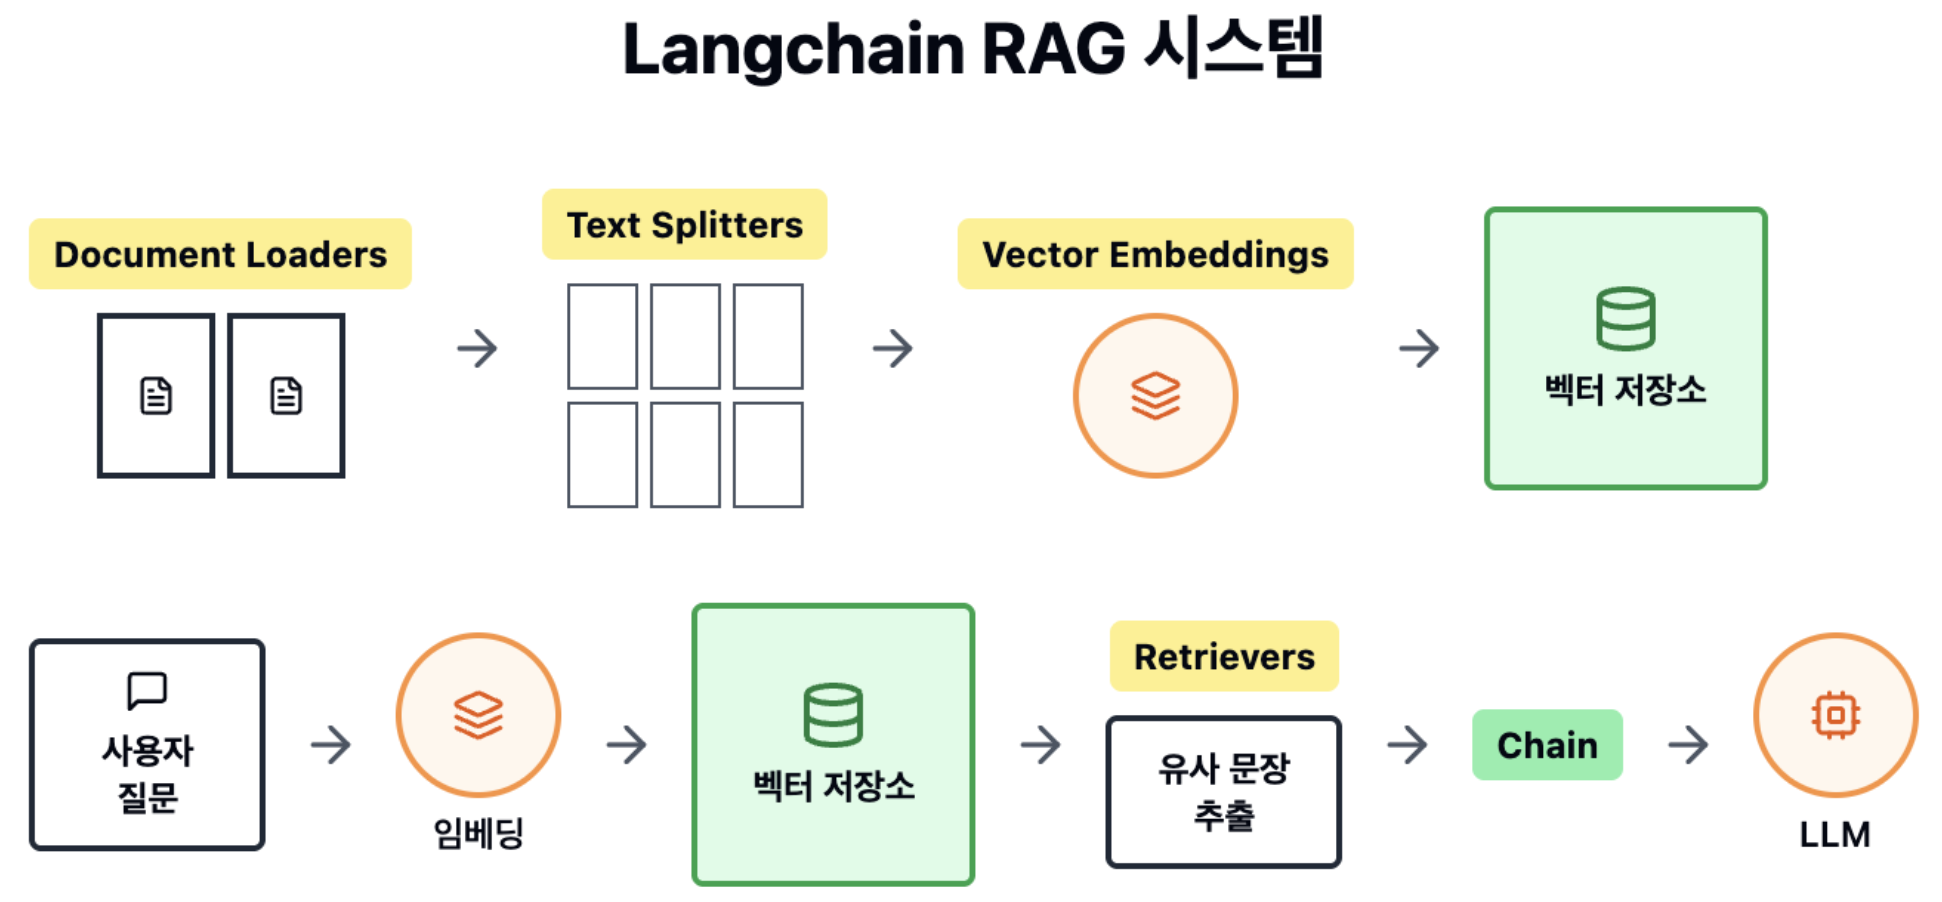

## 학습 목표
- RAG의 기본 개념과 작동 원리 이해
- Chroma 벡터 데이터베이스의 활용법 학습
- LangGraph를 이용한 RAG 워크플로우 구성
- 실제 질의응답 시스템 구현 및 테스트

## 환경 설정 및 데이터 준비


In [1]:
# %pip install langchain==0.3.26 langchain-community==0.3.27 langchain-openai==0.3.8 langgraph==0.2.61 chromadb==1.1.0


In [2]:
# 필요한 라이브러리 설치 및 임포트
import os
import json
from typing import List, Dict, Any, Optional
from pathlib import Path

# LangChain 관련 라이브러리
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import Document
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

# LangGraph 관련 라이브러리
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated

# 기타 라이브러리
import warnings
warnings.filterwarnings('ignore')

print("모든 라이브러리가 성공적으로 임포트되었습니다!")


모든 라이브러리가 성공적으로 임포트되었습니다!


### [API 키 설정](https://platform.openai.com/api-keys)


In [ ]:
# API 키 설정 (선택사항)
os.environ["OPENAI_API_KEY"] = "your_openai_api_key_here"

# API 키 확인
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)


# 벡터 데이터베이스

## 샘플 데이터 로드 (RAG 키워드 데이터)

In [4]:
from langchain_community.document_loaders import TextLoader

DATA_PATH = "./data/"
loader = TextLoader(DATA_PATH+"rag-keywords.txt")

# 전체 파일 로드
documents = loader.load()

In [5]:
if documents:
    print(f"{len(documents)}개의 문서가 성공적으로 로드되었습니다!")
    print(f"첫 번째 문서 미리보기:")
    print(f"내용: {documents[0].page_content[:100]}...")
    print(f"메타데이터: {documents[0].metadata}")
else:
    print("문서 로드에 실패했습니다. 파일 경로를 확인해주세요.")


1개의 문서가 성공적으로 로드되었습니다!
첫 번째 문서 미리보기:
내용: Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태...
메타데이터: {'source': './data/rag-keywords.txt'}


## 문서 분할 실행

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # 각 청크의 최대 크기 (1000자)
    chunk_overlap=200,      # 청크 간 겹치는 부분 (200자)
    length_function=len,    # 길이 계산 함수
    separators=["\n\n", "\n", " ", ""]  # 분할 우선순위: 문단 → 줄 → 공백 → 문자
)


In [7]:
if documents:
    texts = text_splitter.split_documents(documents)
    print(f"{len(documents)}개 문서가 {len(texts)}개의 텍스트 청크로 분할되었습니다.")
    
    # 분할 결과 미리보기
    if texts:
        print(f"첫 번째 청크 미리보기:")
        print(f"길이: {len(texts[0].page_content)}자")
        print(f"내용: {texts[0].page_content[:200]}...")
        print(f"메타데이터: {texts[0].metadata}")
else:
    print("분할할 문서가 없습니다. 이전 단계를 확인해주세요.")
    texts = []


1개 문서가 7개의 텍스트 청크로 분할되었습니다.
첫 번째 청크 미리보기:
길이: 855자
내용: Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정...
메타데이터: {'source': './data/rag-keywords.txt'}


## Chroma 벡터 데이터베이스 설정


In [8]:
try:
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    print("OpenAI 임베딩 모델을 사용합니다. (고성능)")
        
except Exception as e:
    print(f"임베딩 모델 설정 중 오류 발생: {e}")


OpenAI 임베딩 모델을 사용합니다. (고성능)


In [9]:
# Chroma 벡터 데이터베이스 생성
# 기존 데이터베이스가 있다면 삭제하고 새로 생성
import shutil
if os.path.exists("./chroma_db"):
    shutil.rmtree("./chroma_db")

# Chroma 벡터스토어 생성
vectorstore = Chroma.from_documents(
    documents=texts,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

print("Chroma 벡터 데이터베이스가 생성되었습니다.")

Chroma 벡터 데이터베이스가 생성되었습니다.


In [10]:
# 벡터스토어를 검색 가능한 형태로 변환
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}  # 상위 3개 문서 반환
)

print("검색기(Retriever)가 설정되었습니다.")


검색기(Retriever)가 설정되었습니다.


# LangGraph를 이용한 RAG 워크플로우 구성


## LangGraph 상태 정의

In [11]:

class RAGState(TypedDict):
    """RAG 시스템의 상태를 정의하는 클래스"""
    question: str  # 사용자 질문
    retrieved_docs: List[Document]  # 검색된 문서들
    context: str  # 검색된 문서들을 결합한 컨텍스트
    answer: str  # 최종 답변
    sources: List[str]  # 출처 정보 (파일명들)
    messages: Annotated[List[Any], add_messages]  # 메시지 히스토리


## LLM 모델 설정

In [12]:

llm = ChatOpenAI(
        model="gpt-5-mini",
        max_tokens=1000
    )


## RAG 워크플로우 노드들 정의

In [13]:

def retrieve_documents(state: RAGState) -> RAGState:
    """문서 검색 노드"""
    print(f"질문: {state['question']}")
    
    # 벡터 검색 수행
    docs = retriever.get_relevant_documents(state['question'])
    
    # 출처 정보 추출
    sources = []
    if docs:
        for doc in docs:
            source = doc.metadata.get('source', 'Unknown')
            if source not in sources:
                sources.append(source)
    
    print(f"{len(docs)}개의 관련 문서를 찾았습니다.")
    for i, doc in enumerate(docs):
        print(f"  {i+1}. {doc.page_content[:100]}...")
    
    return {
        **state,
        "retrieved_docs": docs,
        "sources": sources
    }


In [14]:

def format_context(state: RAGState) -> RAGState:
    """검색된 문서들을 컨텍스트로 포맷팅"""
    docs = state['retrieved_docs']
    
    # 문서들을 하나의 컨텍스트로 결합
    context_parts = []
    for i, doc in enumerate(docs, 1):
        context_parts.append(f"문서 {i}:\n{doc.page_content}\n")
    
    context = "\n".join(context_parts)
    
    return {
        **state,
        "context": context
    }


In [15]:

def generate_answer(state: RAGState) -> RAGState:
    """답변 생성 노드"""
    question = state['question']
    context = state['context']
    retrieved_docs = state['retrieved_docs']
    sources = state['sources']
    
    # 관련 문서가 없거나 매우 적을 때 처리
    if not retrieved_docs or len(retrieved_docs) == 0:
        answer = "죄송합니다. 해당 질문에 대한 관련 정보를 찾을 수 없습니다."
        return {
            **state,
            "answer": answer
        }
    
    # 관련성 검증: 질문의 핵심 키워드가 문서에 있는지 확인
    question_lower = question.lower()
    
    # 질문에서 핵심 키워드 추출
    question_keywords = []
    if 'rag' in question_lower:
        question_keywords.append('rag')
    if any(word in question_lower for word in ['임베딩', 'embedding']):
        question_keywords.extend(['임베딩', 'embedding'])
    if 'transformer' in question_lower:
        question_keywords.append('transformer')
    if 'attention' in question_lower:
        question_keywords.append('attention')
    if any(word in question_lower for word in ['semantic', '의미', '검색']):
        question_keywords.extend(['semantic', '의미', '검색'])
    if 'chroma' in question_lower:
        question_keywords.append('chroma')
    if 'faiss' in question_lower:
        question_keywords.append('faiss')
    if 'langgraph' in question_lower:
        question_keywords.append('langgraph')
    
    # 질문에 특정 키워드가 있으면 문서에서도 해당 키워드를 찾아야 함
    if question_keywords:
        has_relevant_content = False
        for doc in retrieved_docs:
            doc_content_lower = doc.page_content.lower()
            for keyword in question_keywords:
                if keyword in doc_content_lower:
                    has_relevant_content = True
                    break
            if has_relevant_content:
                break
        
        if not has_relevant_content:
            # 질문의 핵심 키워드가 문서에 없으면 모른다고 답변
            answer = "죄송합니다. 해당 질문에 대한 관련 정보를 찾을 수 없습니다."
            return {
                **state,
                "answer": answer
            }
    # 질문에 특정 키워드가 없으면 일반적인 질문으로 간주하고 답변 생성
    
    # 프롬프트 템플릿 정의 (출처 정보 포함)
    prompt_template = ChatPromptTemplate.from_template("""
        다음 컨텍스트를 바탕으로 질문에 답변해주세요.
        답변 후에는 반드시 출처 정보를 포함해주세요.

        컨텍스트:
        {context}

        질문: {question}

        답변 형식:
        [답변 내용]

        **출처:** {sources}
    """)
    
    # 체인 구성
    chain = prompt_template | llm | StrOutputParser()
    
    # 출처 정보 포맷팅
    sources_text = ", ".join(sources) if sources else "출처 정보 없음"
    
    # 답변 생성
    answer = chain.invoke({
        "context": context,
        "question": question,
        "sources": sources_text
    })
    
    return {
        **state,
        "answer": answer
    }


## LangGraph 워크플로우 구성

In [16]:

def create_rag_workflow():
    """RAG 워크플로우를 생성하고 반환"""
    
    # 상태 그래프 생성
    workflow = StateGraph(RAGState)
    
    # 노드 추가
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("format", format_context)
    workflow.add_node("generate", generate_answer)
    
    # 엣지 정의 (워크플로우 순서)
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "format")
    workflow.add_edge("format", "generate")
    workflow.add_edge("generate", END)
    
    # 그래프 컴파일
    app = workflow.compile()
    
    return app


In [17]:
# RAG 워크플로우 생성
rag_app = create_rag_workflow()
print("RAG 워크플로우가 성공적으로 생성되었습니다.")

RAG 워크플로우가 성공적으로 생성되었습니다.


### RAG 워크플로우 그래프 확인

```
시작
  |
  v
retrieve(문서 검색 노드)
  |     
  v     
format(검색된 문서들을 컨텍스트로 포맷팅)  
  |     
  v     
generate(답변 생성 노드)
  |
  v
종료
```


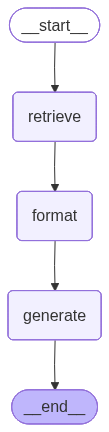

In [18]:
from IPython.display import Image, display

try:
    
    display(
        Image(
            rag_app.get_graph().draw_mermaid_png(
            )
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")


## 실제 질의응답 예제 및 시연


### RAG 시스템 실행 함수

In [19]:

def run_rag_system(question: str):
    """RAG 시스템을 실행하여 질문에 답변"""
    print("=" * 60)
    print(f"RAG 시스템 실행")
    print("=" * 60)
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "retrieved_docs": [],
        "context": "",
        "answer": "",
        "sources": [],
        "messages": []
    }
    
    # 워크플로우 실행
    result = rag_app.invoke(initial_state)
    
    print("\n" + "=" * 60)
    print("최종 결과")
    print("=" * 60)
    print(f"질문: {result['question']}")
    print(f"\n답변: {result['answer']}")
    
    return result


### 사용자 정의 질문 테스트


In [27]:
print("테스트: RAG 질문 (데이터에 없음 - 모른다고 답변해야 함)")
rag_question = "RAG가 무엇인가요?"
result_rag = run_rag_system(rag_question)


테스트: RAG 질문 (데이터에 없음 - 모른다고 답변해야 함)
RAG 시스템 실행
질문: RAG가 무엇인가요?
3개의 관련 문서를 찾았습니다.
  1. 판다스 (Pandas)

정의: 판다스는 파이썬 프로그래밍 언어를 위한 데이터 분석 및 조작 도구를 제공하는 라이브러리입니다. 이는 데이터 분석 작업을 효율적으로 수행할 수 있게 ...
  2. 정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.
예시: OpenAI의 GPT 시리...
  3. VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
예시: 단어 임베딩 벡터...

최종 결과
질문: RAG가 무엇인가요?

답변: 죄송합니다. 해당 질문에 대한 관련 정보를 찾을 수 없습니다.


In [28]:
print("테스트: Transformer Attention 질문 (데이터에 있음 - 답변해야 함)")
transformer_question = "Transformer 모델의 Attention 메커니즘에 대해 설명해주세요."
result_transformer = run_rag_system(transformer_question)


테스트: Transformer Attention 질문 (데이터에 있음 - 답변해야 함)
RAG 시스템 실행
질문: Transformer 모델의 Attention 메커니즘에 대해 설명해주세요.
3개의 관련 문서를 찾았습니다.
  1. 정의: 트랜스포머는 자연어 처리에서 사용되는 딥러닝 모델의 한 유형으로, 주로 번역, 요약, 텍스트 생성 등에 사용됩니다. 이는 Attention 메커니즘을 기반으로 합니다.
예시...
  2. TF-IDF (Term Frequency-Inverse Document Frequency)

정의: TF-IDF는 문서 내에서 단어의 중요도를 평가하는 데 사용되는 통계적 척도입니...
  3. VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
예시: 단어 임베딩 벡터...

최종 결과
질문: Transformer 모델의 Attention 메커니즘에 대해 설명해주세요.

답변: 트랜스포머의 Attention 메커니즘은 입력 시퀀스의 각 요소가 시퀀스 내(또는 다른 시퀀스의) 모든 요소에 '주의'를 분배해 중요한 정보에 더 가중치를 부여하는 기법입니다. 핵심 아이디어와 동작 방식은 다음과 같습니다.

- 입력 토큰들은 각각 쿼리(Query), 키(Key), 값(Value)라는 벡터로 선형 변환됩니다.
- 각 쿼리와 모든 키 간의 유사도(보통 내적)를 계산해 점수(score)를 얻고, 차원 수의 제곱근으로 스케일링한 뒤 softmax를 적용해 가중치(주의분포)를 만듭니다.
- 그 가중치로 값(Value) 벡터들의 가중합을 구하면 해당 쿼리에 대한 출력이 됩니다.
- 수식(간단히): attention(Q,K,V) = softmax( Q K^T / sqrt(d_k) ) V
- 멀티-헤드 어텐션은 서로 다른 부분공간에서 여러 개의 주의를 병렬로 계산해 다양한 관계를 포착하고, 마지막에 합쳐서 사용합니다.
- 어텐션은 문맥에 맞는 단어 간 장거리 